In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

              protected                                                         signature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

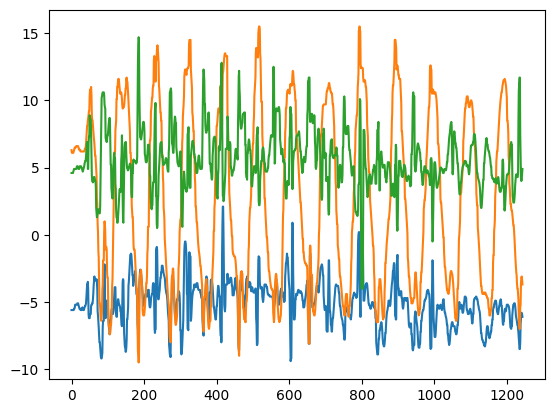

In [ ]:
# Ejemplo de la carga de un archivo *.json con las mediciones de un acelerómetro
RutaFile="/content/drive/MyDrive/Colab Notebooks/Datos/Acelerometro/training/Chest_Fly.4r90g5ml.ingestion-848d69cd95-lzk2f.json"
dataframe = pd.read_json(RutaFile)
print(dataframe.to_string())
Valores = dataframe.iloc[:,:].values
print(Valores.shape)
print(Valores)
print(Valores[7,2][0:-1])

DatosOri1=Valores[7,2][0:-1]
Datos1=np.array(DatosOri1)
print(Datos1.shape)
plt.plot(Datos1)

In [137]:
# Función para cargar datos de un directorio
def cargar_datos(directory):
    # Obtener la lista de archivos en el directorio y ordenarlos alfabéticamente
    files = os.listdir(directory)
    files.sort()

    # Lista para almacenar los datos de todos los archivos
    datos = []

    # Leer datos de cada archivo y agregarlos a la lista
    for file in files:
        # Leer el archivo JSON utilizando Pandas
        df = pd.read_json(os.path.join(directory, file))
        # Extraer los datos de la columna específica del DataFrame
        datos.extend(df.iloc[7, 2][0:-1])

    # Convertir la lista de datos a un arreglo numpy
    datos = np.array(datos)

    return datos

# Función para preprocesar los datos para MLP y Conv1D
def preprocesar_datos_mlp_conv(datos, scaler):
    # Escalar los datos utilizando el objeto scaler proporcionado
    datos_esc = scaler.transform(datos)
    # Definir el tamaño de la muestra para la entrada del modelo (104 en este caso)
    tamano_muestra = 104
    # Calcular el número de patrones en los datos escalados
    num_patrones = len(datos_esc) // tamano_muestra
    # Reorganizar los datos en el formato adecuado para MLP o Conv1D
    X = datos_esc[:num_patrones*tamano_muestra].reshape(num_patrones, tamano_muestra, 3)
    return X

# Función para preprocesar los datos para RNN
def preprocesar_datos_rnn(datos, scaler):
    # No hay diferencia en el preprocesamiento entre RNN y MLP/Conv1D, se reutiliza la función existente
    return preprocesar_datos_mlp_conv(datos, scaler)


In [139]:
# Directorios de datos
training_directory = '/content/drive/MyDrive/Colab Notebooks/Datos/Acelerometro/training/'
testing_directory = '/content/drive/MyDrive/Colab Notebooks/Datos/Acelerometro/testing/'

# Cargar datos de entrenamiento y prueba
datos_entrenamiento = cargar_datos(training_directory)
datos_prueba = cargar_datos(testing_directory)

# Escalar datos
scaler = StandardScaler()
scaler.fit(datos_entrenamiento)
# Preprocesar datos para MLP y Conv1D
X_entrenamiento_mlp_conv = preprocesar_datos_mlp_conv(datos_entrenamiento, scaler)
X_prueba_mlp_conv = preprocesar_datos_mlp_conv(datos_prueba, scaler)
# Preprocesar datos para RNN
X_entrenamiento_rnn = preprocesar_datos_rnn(datos_entrenamiento, scaler)
X_prueba_rnn = preprocesar_datos_rnn(datos_prueba, scaler)

# Definir etiquetas de entrenamiento y prueba
y_entrenamiento = np.repeat(np.arange(5), len(X_entrenamiento_mlp_conv) // 5)
y_prueba = np.repeat(np.arange(5), len(X_prueba_mlp_conv) // 5)

# Ajustar el número de etiquetas de prueba para que coincida con el número total de muestras de prueba
num_muestras_faltantes = len(X_prueba_mlp_conv) - len(y_prueba)
y_prueba = np.concatenate([y_prueba, np.zeros(num_muestras_faltantes)], axis=0)

# Convertir etiquetas a formato one-hot
Y_entrenamiento = keras.utils.to_categorical(y_entrenamiento)
Y_prueba = keras.utils.to_categorical(y_prueba)

# Imprimir dimensiones de los datos
print("Datos Entrenamiento: ", datos_entrenamiento.shape)
print("Datos Test: ", datos_prueba.shape)
print(X_prueba_mlp_conv.shape)
print(X_prueba_rnn.shape)
print(Y_prueba.shape)


Datos Entrenamiento:  (12483, 3)
Datos Test:  (6227, 3)
(59, 104, 3)
(59, 104, 3)
(59, 5)


In [141]:
modelos = {
    "MLP": keras.Sequential([
        keras.layers.Flatten(input_shape=(tamano_muestra, 3)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(5, activation="softmax"),  # Corregido a 5 neuronas para 5 clases
    ]),
    "Conv1D": keras.Sequential([
        keras.layers.Conv1D(32, 3, activation="relu", input_shape=(tamano_muestra, 3)),
        keras.layers.MaxPooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(5, activation="softmax"),  # Corregido a 5 neuronas para 5 clases
    ]),
    "RNN": keras.Sequential([
        keras.layers.LSTM(32, input_shape=(tamano_muestra, 3)),
        keras.layers.Dense(5, activation="softmax"),  # Corregido a 5 neuronas para 5 clases
    ]),
}


Preprocesamiento de Datos En esta fase cargaremos los datos, los dividiremos en conjuntos de entrenamiento y prueba, y los escalaremos si es necesario.**bold text**

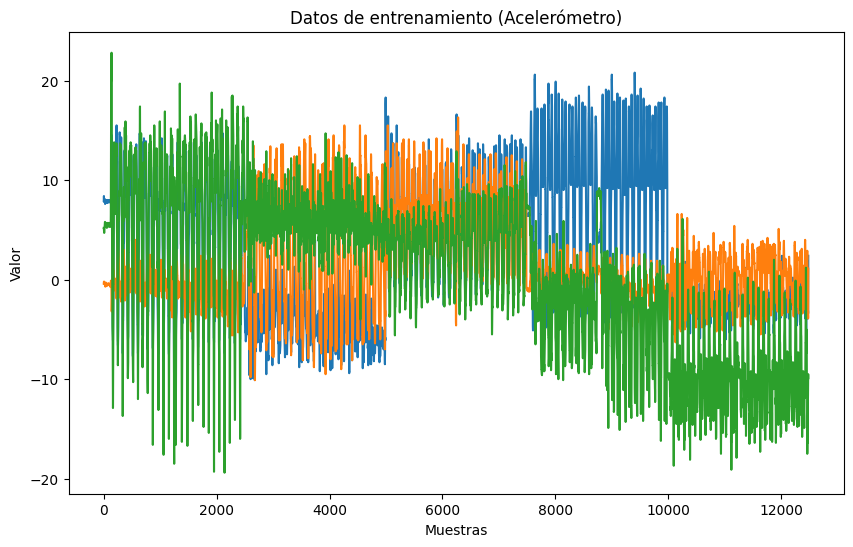

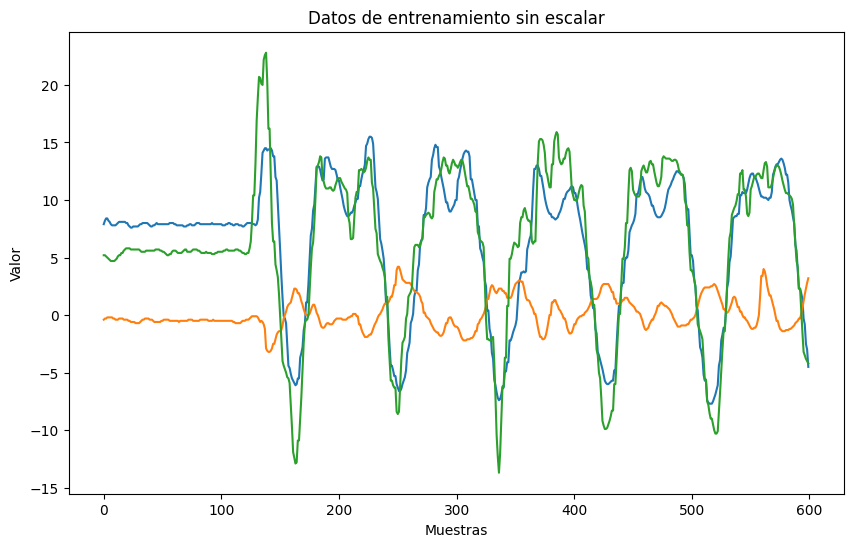

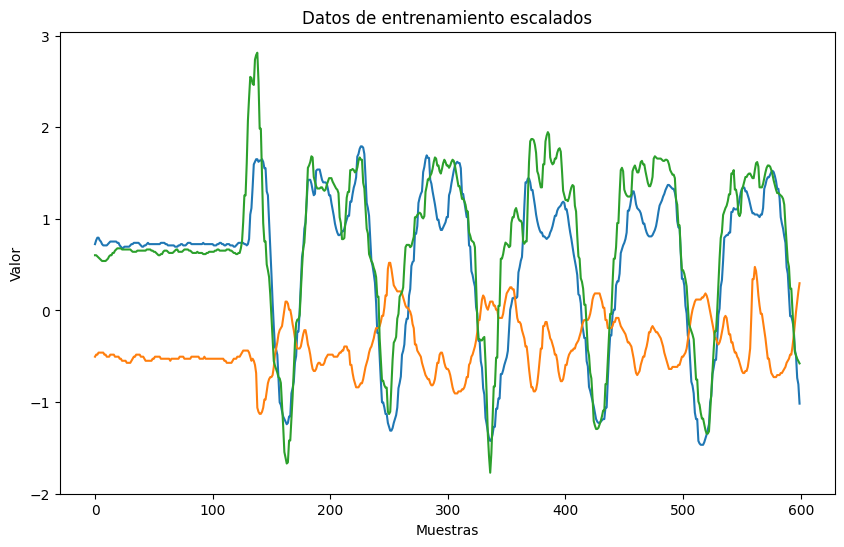

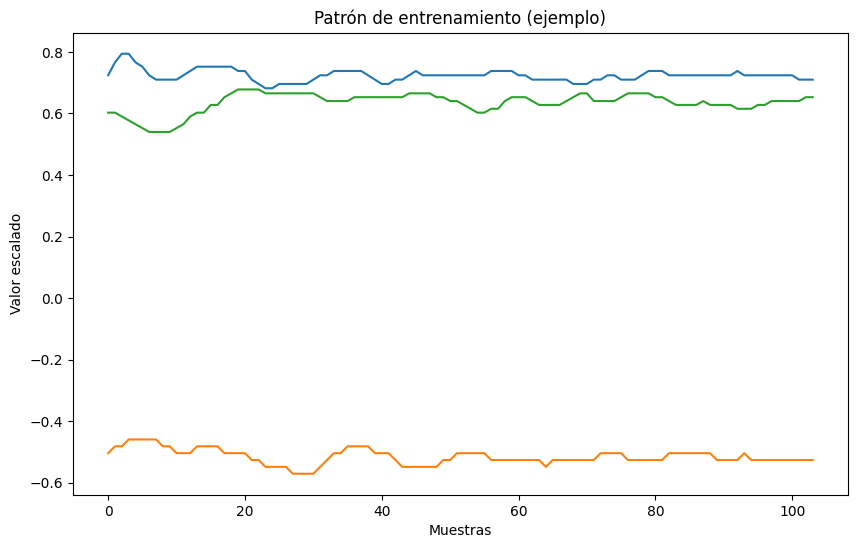

In [143]:
# Visualización de los datos de entrenamiento (Acelerómetro)
plt.figure(figsize=(10, 6))
plt.plot(datos_entrenamiento)
plt.title('Datos de entrenamiento (Acelerómetro)')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.show()

# Visualización de los primeros 100 datos de entrenamiento sin escalar
plt.figure(figsize=(10, 6))
plt.plot(datos_entrenamiento[:600])
plt.title('Datos de entrenamiento sin escalar')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.show()

# Visualización de los primeros 100 datos de entrenamiento escalados
plt.figure(figsize=(10, 6))
plt.plot(scaler.transform(datos_entrenamiento[:600]))
plt.title('Datos de entrenamiento escalados')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.show()

# Visualización de un patrón de entrenamiento (ejemplo)
plt.figure(figsize=(10, 6))
plt.plot(X_entrenamiento_mlp_conv[0])
plt.title('Patrón de entrenamiento (ejemplo)')
plt.xlabel('Muestras')
plt.ylabel('Valor escalado')
plt.show()


Fase 2: Definición y Entrenamiento de Modelos
Aquí definiremos los modelos MLP, Conv1D y RNN, los entrenaremos con los datos de entrenamiento y registraremos sus historias de entrenamiento.

In [144]:
# Entrenamiento y generación de esquemas
historias = {}
for nombre, modelo in modelos.items():
    print(f"Entrenando y generando esquema para el modelo {nombre}")
    modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    modelo.summary()  # Mostrar resumen del modelo
    historia = modelo.fit(X_entrenamiento_mlp_conv if nombre in ["MLP", "Conv1D"] else X_entrenamiento_rnn,
                           Y_entrenamiento,
                           epochs=100,
                           batch_size=None if nombre == "RNN" else 32,
                           verbose=0)
    historias[nombre] = historia

Entrenando y generando esquema para el modelo MLP
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 312)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                20032     
                                                                 
 dense_77 (Dense)            (None, 32)                2080      
                                                                 
 dense_78 (Dense)            (None, 5)                 165       
                                                                 
Total params: 22277 (87.02 KB)
Trainable params: 22277 (87.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Entrenando y generando esquema para el modelo Conv1D
Model: "sequential_40"
_______________________

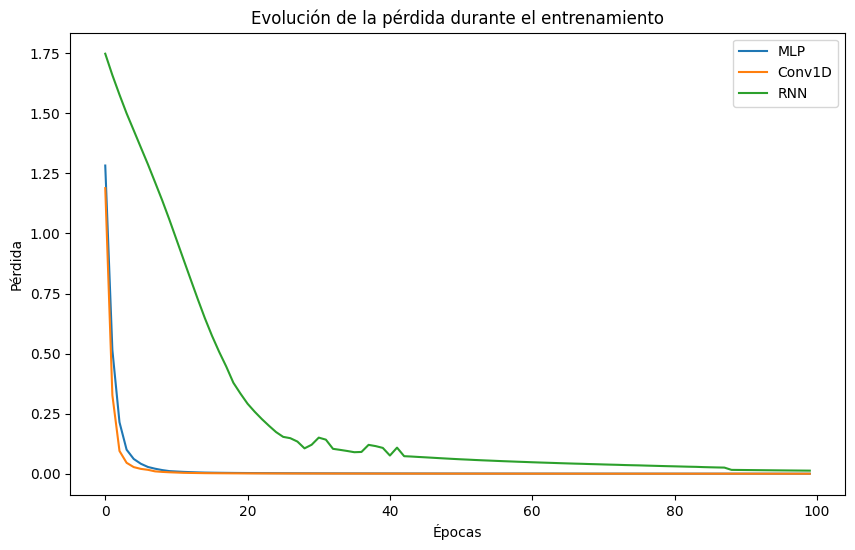

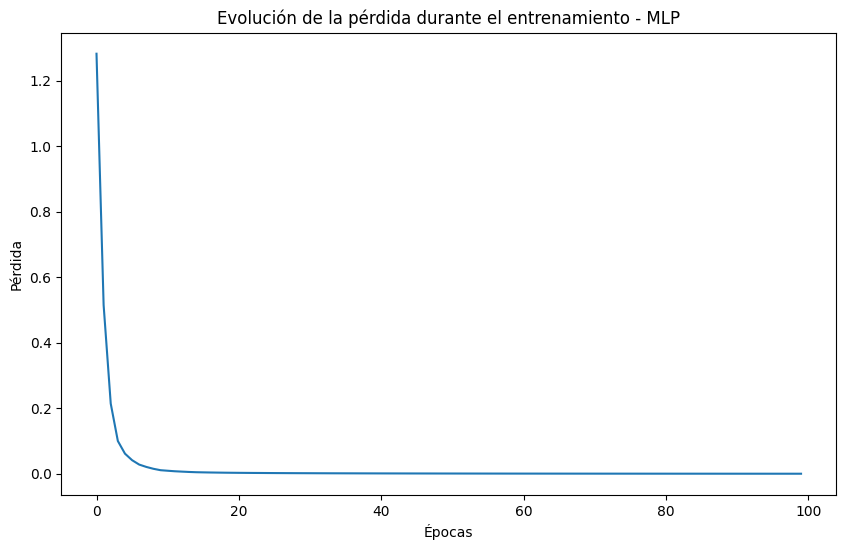

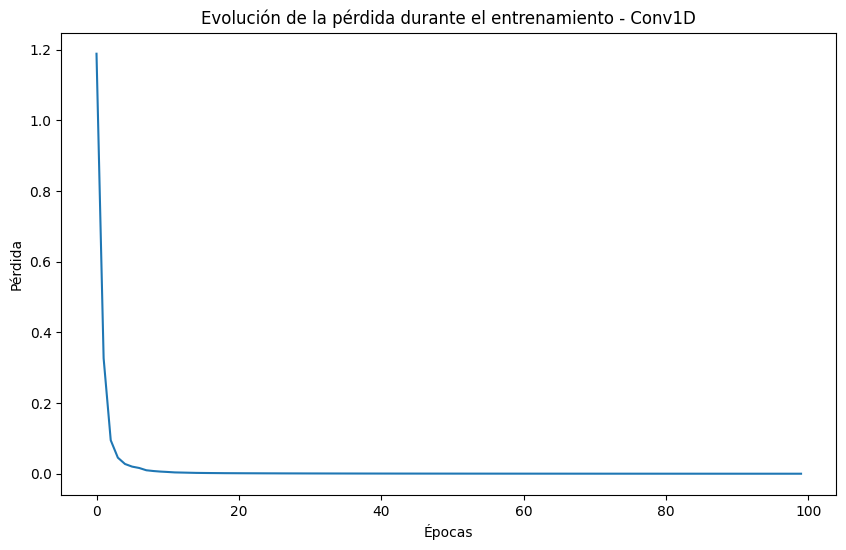

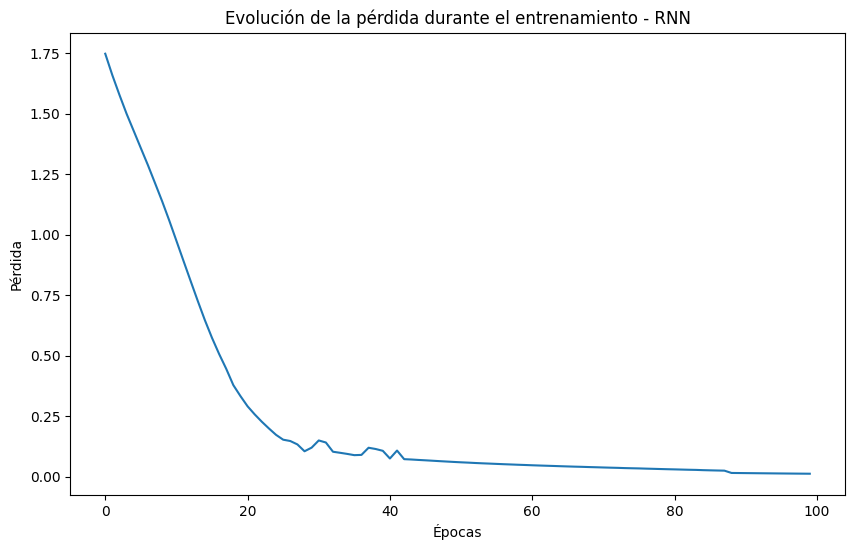

In [145]:
# Gráfica de la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
for nombre, historia in historias.items():
    plt.plot(historia.history['loss'], label=nombre)
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Gráficas de la evolución de la pérdida durante el entrenamiento para cada modelo
for nombre, historia in historias.items():
    plt.figure(figsize=(10, 6))
    plt.plot(historia.history['loss'])
    plt.title(f'Evolución de la pérdida durante el entrenamiento - {nombre}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.show()



Modelo: MLP
Pérdida: 2.369173288345337
Precisión: 0.7627118825912476
2/2 [==============================] - 0s 5ms/step
Matriz de confusión:
[[11  0  0  0  4]
 [ 1 10  0  0  0]
 [ 0  2  9  0  0]
 [ 0  0  3  8  0]
 [ 0  0  0  4  7]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81        15
         1.0       0.83      0.91      0.87        11
         2.0       0.75      0.82      0.78        11
         3.0       0.67      0.73      0.70        11
         4.0       0.64      0.64      0.64        11

    accuracy                           0.76        59
   macro avg       0.76      0.76      0.76        59
weighted avg       0.77      0.76      0.76        59



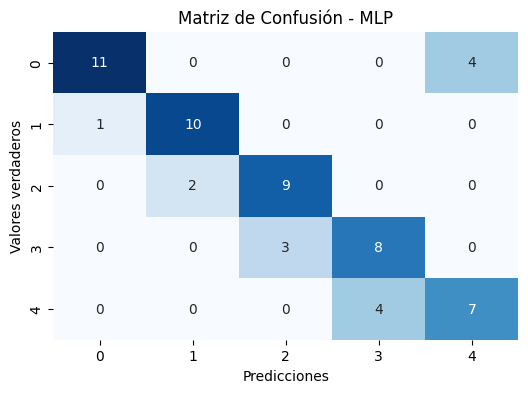

Modelo: Conv1D
Pérdida: 2.7176055908203125
Precisión: 0.7627118825912476
2/2 [==============================] - 0s 7ms/step
Matriz de confusión:
[[11  0  0  0  4]
 [ 1 10  0  0  0]
 [ 0  2  9  0  0]
 [ 0  0  3  8  0]
 [ 0  0  0  4  7]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81        15
         1.0       0.83      0.91      0.87        11
         2.0       0.75      0.82      0.78        11
         3.0       0.67      0.73      0.70        11
         4.0       0.64      0.64      0.64        11

    accuracy                           0.76        59
   macro avg       0.76      0.76      0.76        59
weighted avg       0.77      0.76      0.76        59



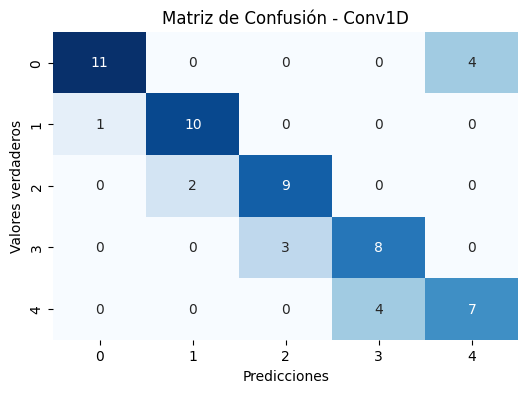

Modelo: RNN
Pérdida: 1.602267861366272
Precisión: 0.7288135886192322
2/2 [==============================] - 0s 27ms/step
Matriz de confusión:
[[11  0  0  0  4]
 [ 1 10  0  0  0]
 [ 1  2  7  1  0]
 [ 0  0  3  8  0]
 [ 0  0  0  4  7]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.73      0.79        15
         1.0       0.83      0.91      0.87        11
         2.0       0.70      0.64      0.67        11
         3.0       0.62      0.73      0.67        11
         4.0       0.64      0.64      0.64        11

    accuracy                           0.73        59
   macro avg       0.73      0.73      0.72        59
weighted avg       0.73      0.73      0.73        59



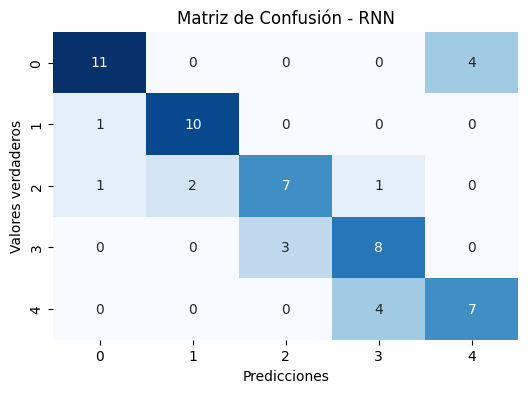

In [147]:
# Evaluación de modelos y visualización de la matriz de confusión
for nombre, modelo in modelos.items():
    print(f"Modelo: {nombre}")
    resultados = modelo.evaluate(X_prueba_mlp_conv if nombre in ["MLP", "Conv1D"] else X_prueba_rnn,
                                  Y_prueba,
                                  verbose=0)
    print("Pérdida:", resultados[0])
    print("Precisión:", resultados[1])

    # Predicciones y matriz de confusión
    predicciones = modelo.predict(X_prueba_mlp_conv if nombre in ["MLP", "Conv1D"] else X_prueba_rnn)
    y_pred_class = np.argmax(predicciones, axis=1)
    print("Matriz de confusión:")
    cm = confusion_matrix(y_prueba, y_pred_class)
    print(cm)
    print("Reporte de clasificación:")
    print(classification_report(y_prueba, y_pred_class))

    # Gráfica de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores verdaderos')
    plt.show()


In [148]:
# Evaluación de modelos y selección del mejor modelo
mejor_modelo = None
mejor_precision = 0

for nombre, modelo in modelos.items():
    # Entrenar el modelo y guardar la historia
    historia = modelo.fit(X_entrenamiento_mlp_conv if nombre in ["MLP", "Conv1D"] else X_entrenamiento_rnn,
                           Y_entrenamiento,
                           epochs=100,
                           batch_size=None if nombre == "RNN" else 32,
                           verbose=0)

    # Evaluar el modelo en el conjunto de prueba
    resultados = modelo.evaluate(X_prueba_mlp_conv if nombre in ["MLP", "Conv1D"] else X_prueba_rnn,
                                  Y_prueba,
                                  verbose=0)
    perdida = resultados[0]
    precision = resultados[1]

    # Imprimir los resultados
    print(f"Modelo: {nombre}")
    print("Pérdida:", perdida)
    print("Precisión:", precision)

    # Comparar con el mejor modelo actual
    if precision > mejor_precision:
        mejor_modelo = nombre
        mejor_precision = precision

# Imprimir el mejor modelo y su precisión
print(f"El mejor modelo es {mejor_modelo} con una precisión de {mejor_precision}.")


Modelo: MLP
Pérdida: 2.6586880683898926
Precisión: 0.7627118825912476
Modelo: Conv1D
Pérdida: 2.976167917251587
Precisión: 0.7627118825912476
Modelo: RNN
Pérdida: 1.7101041078567505
Precisión: 0.7457627058029175
El mejor modelo es MLP con una precisión de 0.7627118825912476.


In [131]:
import tensorflow as tf

# Código para crear y compilar el modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(104, 3)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # El número de clases es 5 según el contexto
])

modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
# ...

# Guardar el modelo en formato h5
modelo.save('modelo.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [135]:
import tensorflow as tf
import numpy as np

# Cargar el modelo
modelo = tf.keras.models.load_model('modelo.h5')

# Función para cargar y preprocesar los datos de un archivo JSON
def cargar_datos_json(archivo_json):
    with open(archivo_json, 'r') as f:
        datos_json = json.load(f)

    # Extraer los valores del "payload"
    valores = datos_json['payload']['values']

    # Convertir los valores a un arreglo numpy
    datos_acelerometro = np.array(valores)

    return datos_acelerometro


# Función para inferir la clase a partir de las predicciones
def inferir_clase(prediccion):
    clases = ['Bicep_Curl', 'Chest_Fly', 'Front_Raise', 'Lateral_Raise', 'reverse_Fly']
    indice_clase = np.argmax(prediccion)
    return clases[indice_clase]

# Ruta al archivo JSON que contiene los datos del acelerómetro
archivo_json = '/content/Bicep_Curl.4r90jnsk.ingestion-848d69cd95-ttl72.json'

# Cargar y preprocesar los datos
datos_acelerometro = cargar_datos_json(archivo_json)

# Asegurarnos de que los datos tienen al menos 104 muestras
if datos_acelerometro.shape[0] < 104:
    print("El archivo JSON no tiene suficientes muestras para realizar una predicción.")
else:
    # Tomar solo las primeras 104 muestras (o ajustar según sea necesario)
    datos_acelerometro = datos_acelerometro[:104]

    # Realizar la predicción
    prediccion = modelo.predict(datos_acelerometro.reshape(1, 104, 3))  # Reshape para que coincida con la forma esperada por el modelo

    # Obtener la clase predicha
    clase_predicha = inferir_clase(prediccion)
    print("Clase predicha:", clase_predicha)


1/1 [==============================] - 0s 144ms/step
Clase predicha: Chest_Fly
